One of the teams in your company is struggling to correctly plan their sprint commitments because of the unplanned efforts. These come mainly from bug fixing since they have very tight SLAs. They wish they can predict the amount of bugs they will be receiving within the sprint so they can account for it when planning the sprint. 

They have provided a raw export of bud IDs and creation date to see if you can help them with their problem. 

Load the raw data in a dataframe and inspect them:

In [27]:
import pandas as pd

raw_data=pd.read_csv('ticket-list.csv')
print(raw_data.head())

  issue_key     created
0   PTL-953  2021-06-15
1  PTL-1146  2021-07-01
2  PTL-1209  2021-07-01
3  PTL-1327  2021-11-16
4  PTL-1329  2021-09-20


Transform this into a dataframe containing the number of issues created each day to create a data series.

In [28]:
raw_data['created']=pd.to_datetime(raw_data['created'])
data=raw_data.groupby(raw_data['created'].dt.date).size().reset_index(name='Number_of_Issues')
data.set_index('created', inplace=True)
print(data.head())

            Number_of_Issues
created                     
2021-01-04                 2
2021-01-05                 2
2021-01-06                 2
2021-01-07                 1
2021-01-08                 1


Plot the data series

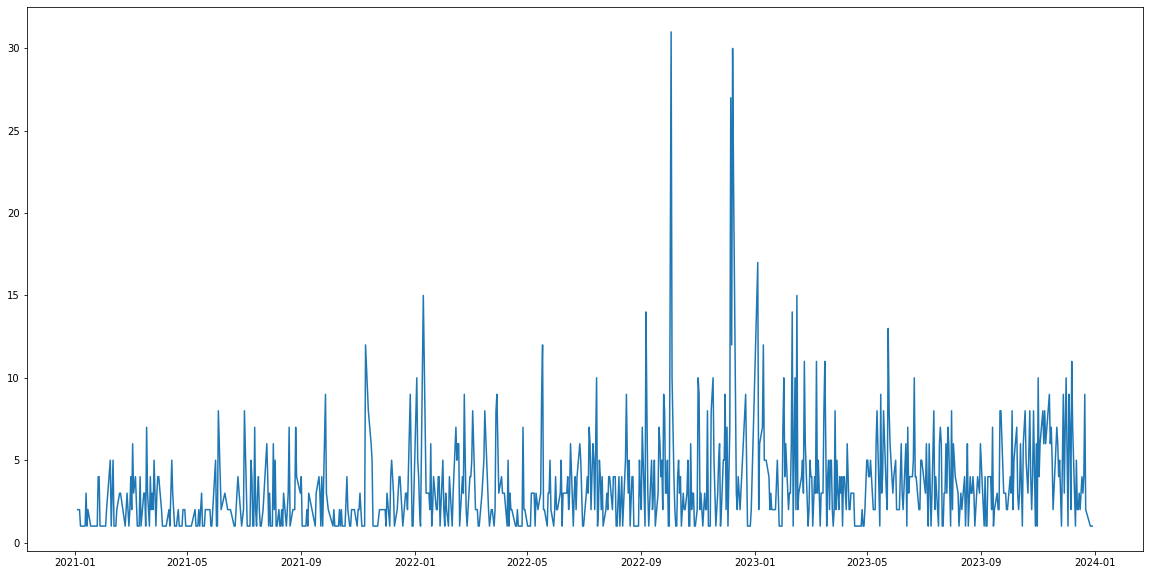

In [29]:
import matplotlib.pyplot as plt
plt.plot(data)

Note that many days have 0 issues created but the plot is not capturing that. Let's fill in the gaps with zeros to have a continuous series and plot the series again.

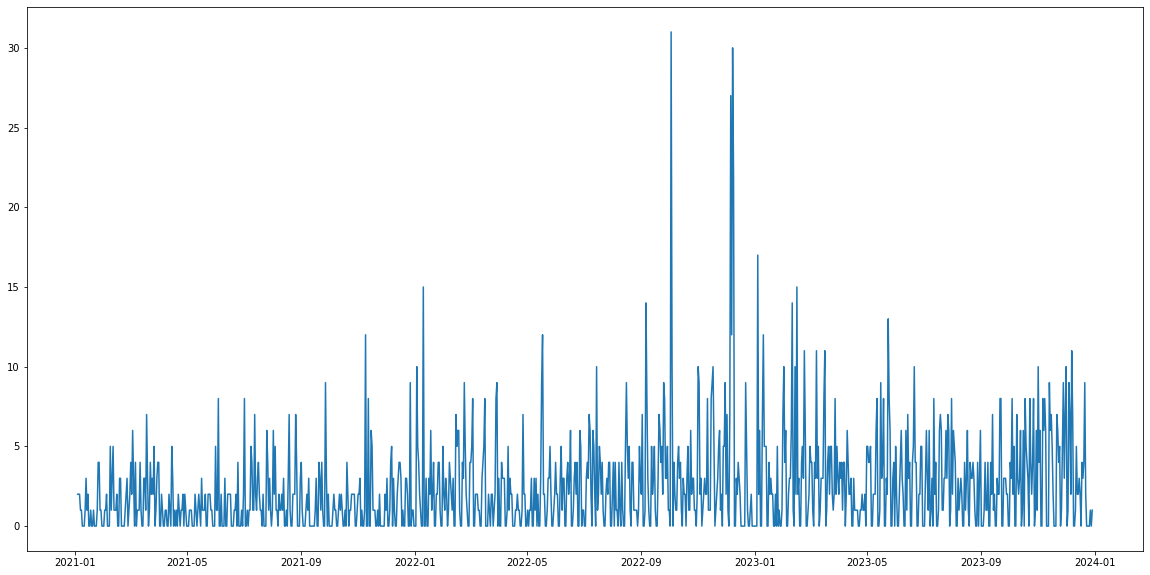

In [30]:
date_range = pd.date_range(data.index.min(), data.index.max())
data = data.reindex(date_range, fill_value=0)
plt.plot(data)

Let's check if there are any outliers in our data series:

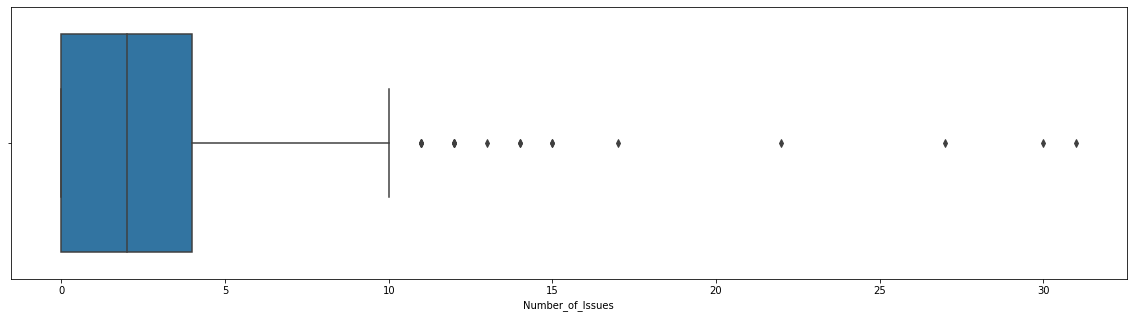

In [31]:
import seaborn as sns

fig=plt.subplots(figsize=(20,5))
ax =sns.boxplot(x=data['Number_of_Issues'],whis=1.5)

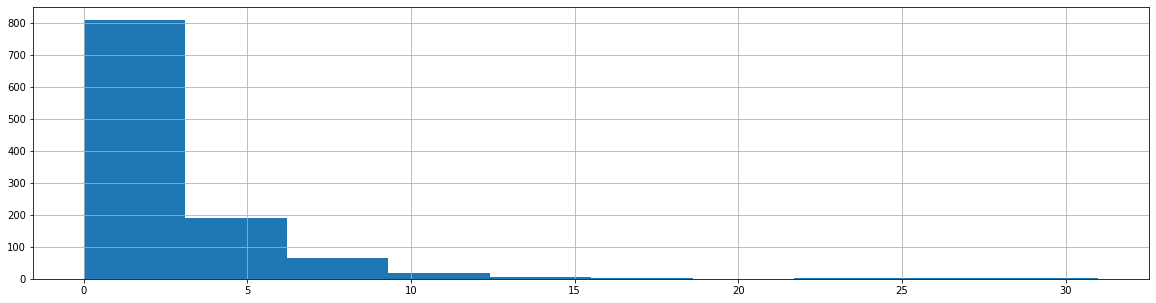

In [32]:
fig = data.Number_of_Issues.hist(figsize=(20,5))

Clean outliers

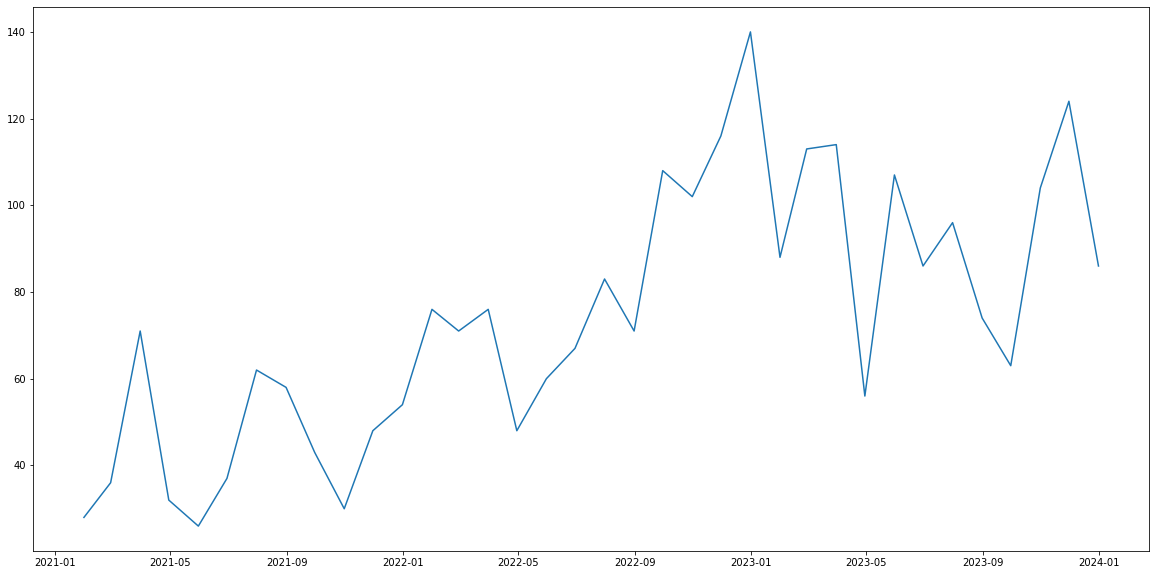

In [33]:
monthly_data = data.resample('M').sum()
plt.plot(monthly_data)

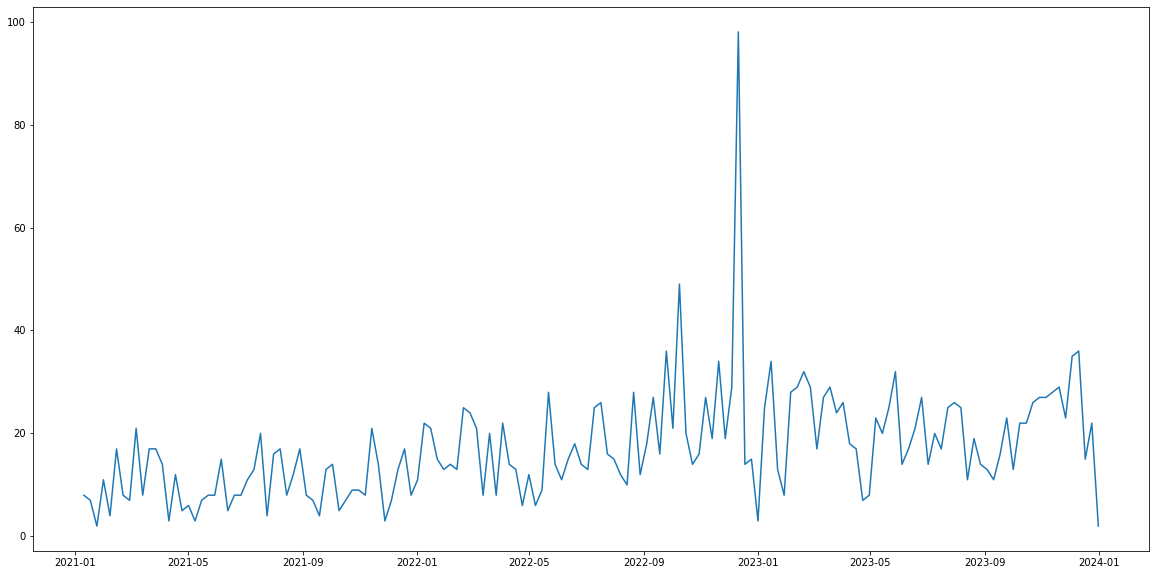

In [34]:
weekly_data = data.resample('W').sum()
plt.plot(weekly_data)

Time series decomposition

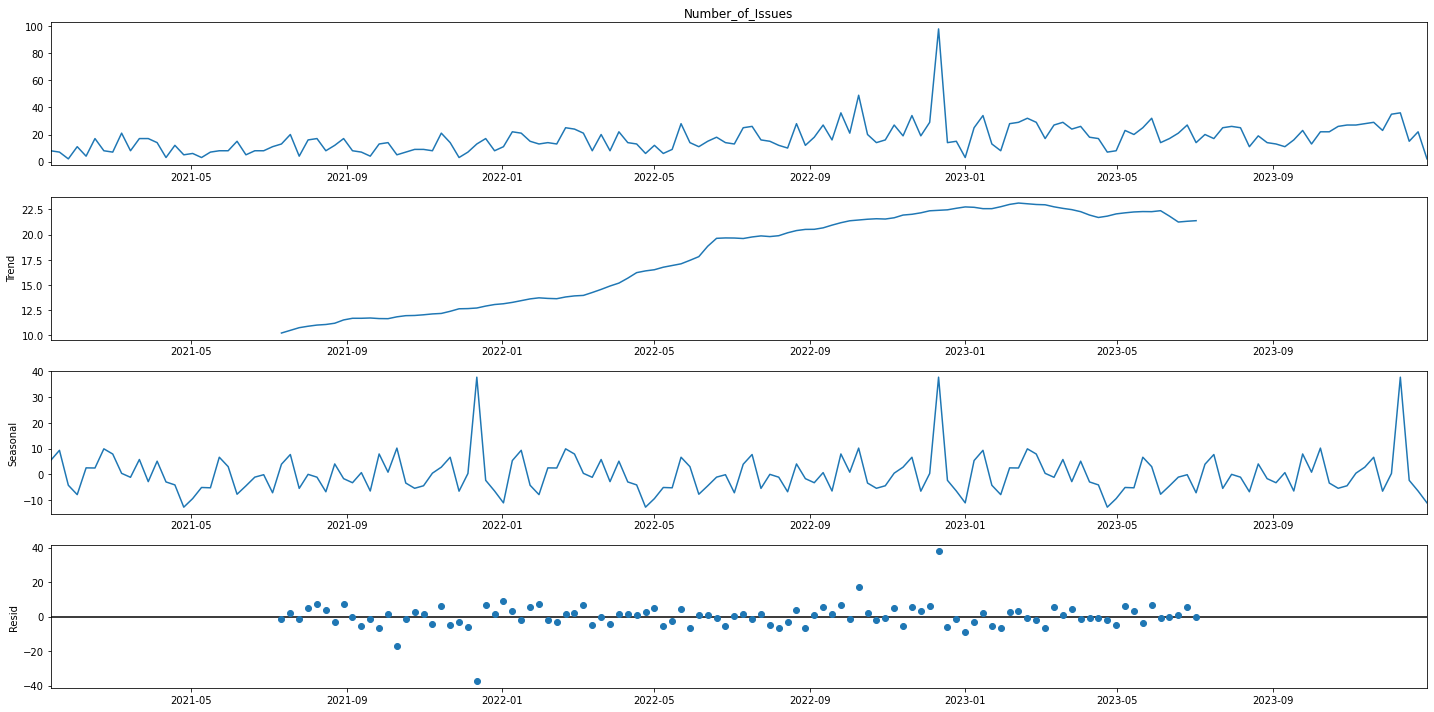

In [35]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(weekly_data.Number_of_Issues, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

Split the series into training and test sets

In [36]:
train_len = 850
train = data[0:train_len]
test = data[train_len:]

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 365)) 
model_fit = model.fit()
print(model_fit.params)

/home/jyague/repos/SARIMA-forecast/env/lib64/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


In [ ]:
forecast = model_fit.get_forecast(steps=len(test))
forecast_index = pd.date_range(train.index[-1] + pd.DateOffset(days=1), periods=len(test), freq='D')
forecast_df = pd.DataFrame({'Forecasted_Number_of_Issues': forecast.predicted_mean.values}, index=forecast_index)

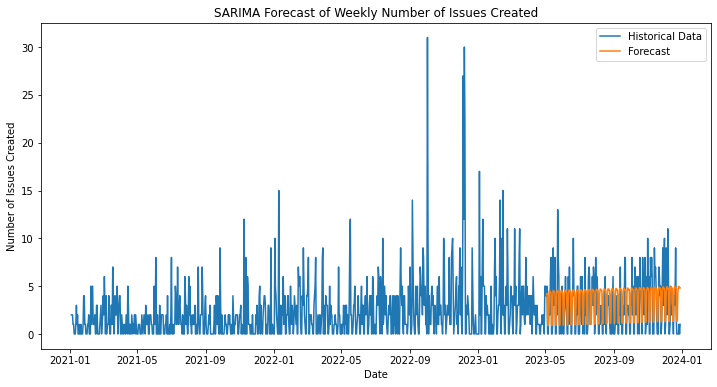

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Number_of_Issues'], label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Forecasted_Number_of_Issues'], label='Forecast')
plt.title('SARIMA Forecast of Weekly Number of Issues Created')
plt.xlabel('Date')
plt.ylabel('Number of Issues Created')
plt.legend()
plt.show()